In [9]:
! pwd

/Users/eas/Documents/GitHub/fair_neighborhood/notebooks


In [ ]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import torch
from scipy.sparse import lil_matrix

from prettytable import PrettyTable

from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import Deduplicate, MinRating, MinItemsPerUser
from recpack.scenarios import WeakGeneralization

from hyperopt import fmin, tpe, hp

# helpers & metrics
from src.helper_functions.data_formatting import *
from src.helper_functions.metrics_accuracy import *
from src.helper_functions.metrics_coverage import *
from src.helper_functions.metrics_exposure import *

# models
from src.recommenders.ease import myEASE
from src.recommenders.slim_bn import BNSLIM
from src.recommenders.fslr import FSLR
from src.recommenders.slim_bn_admm import BNSLIM_ADMM
from src.recommenders.mf_fair import FairMF
from src.recommenders.fda import FDA_bpr

import json
import itertools
import time
# import pickle

import matplotlib.pyplot as plt

## Data Loading

In [11]:
# load ratings.dat from ml-1m folder
ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, usecols=[0,1,2,3], names=["User_id","Item_id","Rating","Timestamp"], engine="python")

# load movies.dat from ml-1m folder
movies = pd.read_csv("ml-1m/movies.dat", sep="::", header=None, usecols=[0,2], names=["Item_id", "Genre"], encoding="latin-1", engine="python")
movies["Genre"] = movies["Genre"].apply(lambda x: x.split("|"))
movies = movies.explode("Genre")

# load users.dat from ml-1m folder
users = pd.read_csv("ml-1m/users.dat", sep="::", header=None, usecols=[0,1], names=["User_id", "Gender"], encoding="latin-1", engine="python")

# replace "M" with 0 and "F" with 1 in the "Gender" column
users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})

# join ratings on users with User_id
ratings = pd.merge(ratings, users, on="User_id", how="left")

/var/folders/p_/s2y5jw396vjd9c8fql74n7600000gn/T/ipykernel_6858/3269733279.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})


## Data Preprocessing

In [12]:
ratings_pp = DataFramePreprocessor("Item_id", "User_id","Timestamp")

# define filters
deduplicate = Deduplicate("Item_id", "User_id", "Timestamp")
min_rating_filter = MinRating(4, "Rating")
min_items_per_user_filter = MinItemsPerUser(10, "Item_id", "User_id")

# add filters to pre-processor
ratings_pp.add_filter(deduplicate)
ratings_pp.add_filter(min_rating_filter)
ratings_pp.add_filter(min_items_per_user_filter)

# create interaction matrix object
im = ratings_pp.process(ratings)

# apply filters to ratings frame directly
ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(ratings)))

movies = movies[movies["Item_id"].isin(ratings["Item_id"].unique())] # only keep items that are in the filtered ratings
raw_genre_dict = dict(movies.groupby("Genre")["Item_id"].apply(lambda x: list(set(x))))

# genre - inner iids dictionary
inner_genre_dict = {
    genre: get_inner_item_ids(ratings_pp, raw_iids)
    for genre, raw_iids in raw_genre_dict.items()
    }

  0%|          | 0/574619 [00:00<?, ?it/s]

  0%|          | 0/574619 [00:00<?, ?it/s]

## Data Statistics

In [13]:
# compute sparsity after filtering
sparsity = 1 - im.density

# calculate user interaction and item popularity ranges
user_interactions = im.binary_values.sum(axis=1)
item_popularities = im.binary_values.sum(axis=0)
print(f"User interaction ranges from {user_interactions.min()} to {user_interactions.max()}. Item popularity ranges from {item_popularities.min()} to {item_popularities.max()}.")

# get the raw ids of all users involved
raw_uids = get_raw_user_ids(ratings_pp, im.active_users)

# create uid - gender mapping df
gender_mapping_df = ratings[ratings["User_id"].isin(raw_uids)][["User_id", "Gender"]].drop_duplicates()

# get the raw/inner ids of all females involved
raw_uids_f = gender_mapping_df.loc[gender_mapping_df["Gender"] == 1, "User_id"].to_numpy()
inner_uids_f = get_inner_user_ids(ratings_pp, raw_uids_f)

# get the raw/inner ids of all males involved
raw_uids_m = gender_mapping_df.loc[gender_mapping_df["Gender"] == 0, "User_id"].to_numpy()
inner_uids_m = get_inner_user_ids(ratings_pp, raw_uids_m)

num_interactions_f, num_interactions_m = im.binary_values[inner_uids_f].sum(), im.binary_values[inner_uids_m].sum()

# table stats
statTable1 = PrettyTable(["data set","|U|","|I|","int(I)","sparsity"])
statTable1.add_row(["ML1M", str(im.num_active_users), str(im.num_active_items), str(im.num_interactions), str(round(sparsity*100,2))])
print(statTable1)

statTable2 = PrettyTable(["data set","attribute","|F|","int(F)","|M|","int(M)"])
statTable2.add_row(["ML1M", "gender", str(len(raw_uids_f)), str(num_interactions_f), str(len(raw_uids_m)), str(num_interactions_m)])
print(statTable2)

User interaction ranges from 10 to 1435. Item popularity ranges from 1 to 2832.
+----------+------+------+--------+----------+
| data set | |U|  | |I|  | int(I) | sparsity |
+----------+------+------+--------+----------+
|   ML1M   | 5950 | 3532 | 574619 |  97.27   |
+----------+------+------+--------+----------+
+----------+-----------+------+--------+------+--------+
| data set | attribute | |F|  | int(F) | |M|  | int(M) |
+----------+-----------+------+--------+------+--------+
|   ML1M   |   gender  | 1682 | 145372 | 4268 | 429247 |
+----------+-----------+------+--------+------+--------+


<Figure size 1500x1000 with 0 Axes>

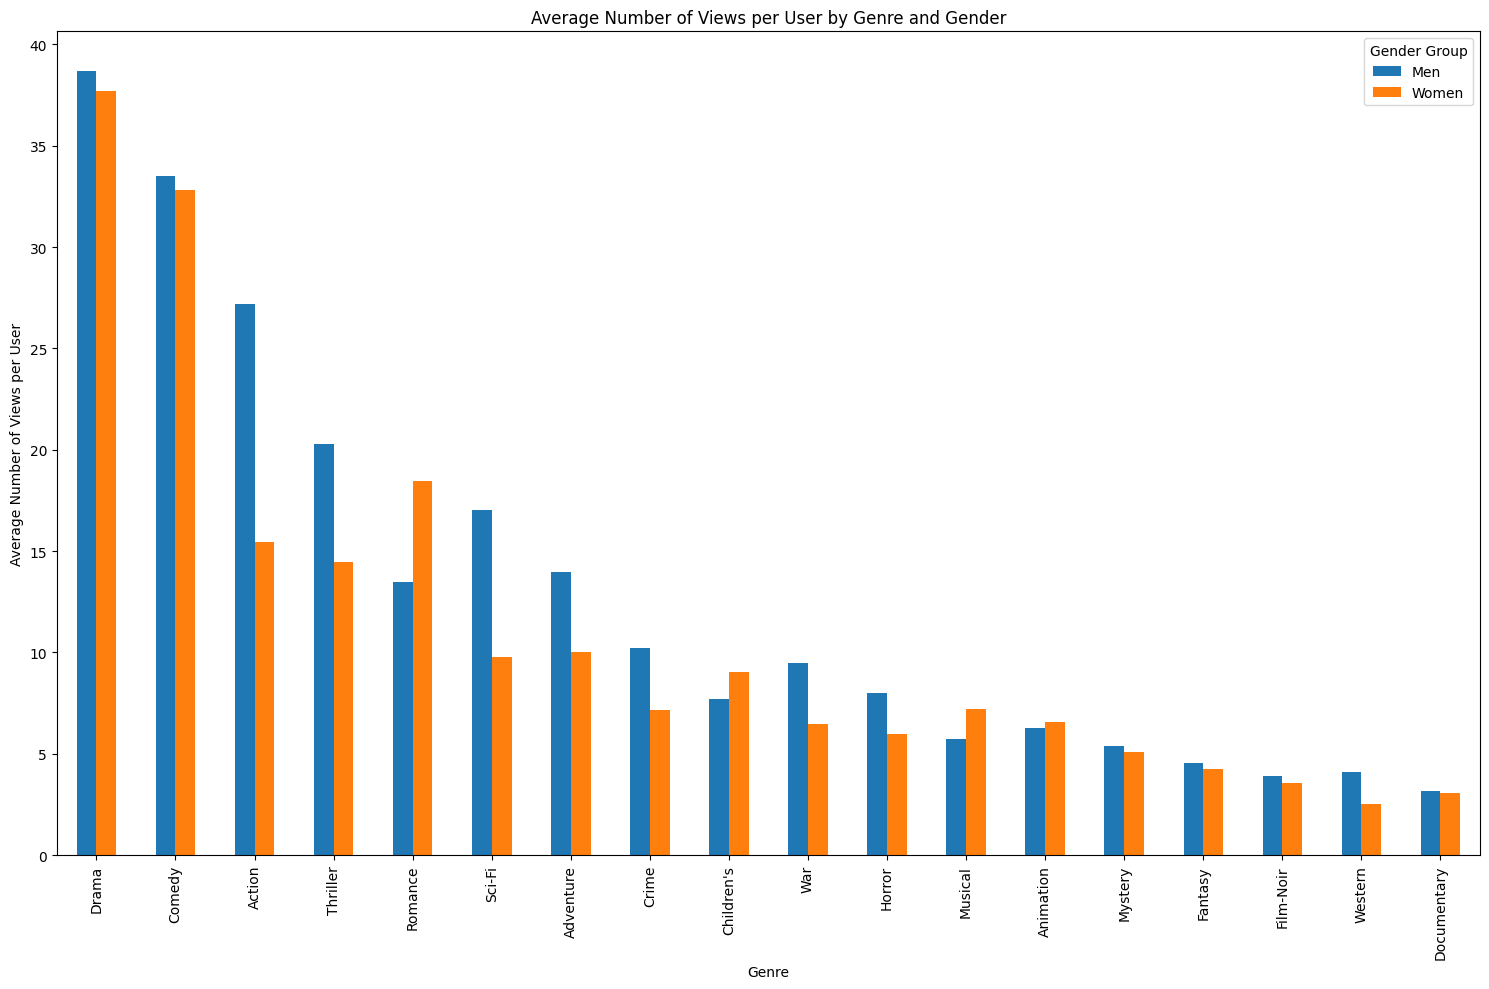

In [14]:
ratings_merged = pd.merge(ratings, movies, on="Item_id", how="left")

# Group by gender: 0 for Men and 1 for Women
ratings_merged["Gender_Group"] = (ratings_merged["Gender"] == 1).astype(int)

# Sum the number of interactions for each user within each genre and gender group
user_genre_gender_sum = ratings_merged.groupby(["User_id", "Genre", "Gender_Group"]).size().reset_index(name="Interactions")

# Calculate the average number of interactions per user for each genre and gender group
genre_gender_avg_interactions = user_genre_gender_sum.groupby(["Genre", "Gender_Group"])["Interactions"].mean().reset_index()

# Pivot the data for plotting
genre_gender_avg_interactions_pivot = genre_gender_avg_interactions.pivot(index="Genre", columns="Gender_Group", values="Interactions").fillna(0)

# Sort genres by average interactions
genre_gender_avg_interactions_pivot["Total"] = (genre_gender_avg_interactions_pivot[0] + genre_gender_avg_interactions_pivot[1]) / 2
genre_gender_avg_interactions_pivot_sorted = genre_gender_avg_interactions_pivot.sort_values(by="Total", ascending=False).drop(columns="Total")

# Plot
plt.figure(figsize=(15, 10))
genre_gender_avg_interactions_pivot_sorted.plot(kind="bar", figsize=(15,10))

plt.title("Average Number of Views per User by Genre and Gender")
plt.xlabel("Genre")
plt.ylabel("Average Number of Views per User")
plt.legend(["Men", "Women"], title="Gender Group")
plt.tight_layout()
plt.show()

## Experiments

In [15]:
# define K for Top-K
K = 10

# Define alpha, the parameter that balances the importance of NDCG and Equity in the objective function.
# Setting alpha = 0.5 gives equal weight to both metrics, aiming to balance relevance (NDCG) and fairness (Equity).
# Adjusting alpha allows for prioritizing one metric over the other.
# For instance, setting alpha closer to 1.0 would prioritize NDCG (accuracy), while setting it closer to 0.0 would prioritize Equity (fairness).
alpha = 0.2

# define seed; seeds tested (1452, 1994, 42, 7, 13800)
SEED = 1994

# define scenario
# Note: Due to the nature of the utilized algorithms (User-User neighborhood methods), 
# only scenarios that include the 'validation in' set in the 'validation training' set, 
# and the 'test in' set in the 'full training' set, are applicable.
scenario = WeakGeneralization(validation=True, seed=SEED)
scenario.split(im)

# define time threshold
SECONDS = 24*3600

# define number of evaluations
EVALUATIONS = 50

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
def accuracy_objective(model, fit_args={}):
    model.fit(scenario.validation_training_data.binary_values, **fit_args)

    # generate predictions and mask training interactions
    predictions = model.predict(scenario.validation_training_data.binary_values).toarray()
    predictions[scenario.validation_training_data.binary_values.nonzero()] = -np.inf

    ndcg, _ = tndcg_at_n(predictions, scenario.validation_data_out.binary_values, K)

    return 1-ndcg

def combined_objective(model, fit_args={}):
    model.fit(scenario.validation_training_data.binary_values, **fit_args)

    if "users_features" in fit_args: #fda
        predictions = model.model_.predict().toarray()
    else:
        predictions = model.predict(scenario.validation_training_data.binary_values).toarray()
    predictions[scenario.validation_training_data.binary_values.nonzero()] = -np.inf

    ndcg, _ = tndcg_at_n(predictions, scenario.validation_data_out.binary_values, K)
    equity, _, _ = c_equity_at_n(predictions[inner_uids_f, :], predictions[inner_uids_m, :], inner_genre_dict, K)

    return alpha * (1-ndcg) + (1 - alpha) * equity

In [ ]:
# for fairmf
sst_field = torch.zeros((im.num_active_users, im.num_active_items), dtype=torch.bool)
sst_field[inner_uids_f, :] = True

# for fda
users_features = np.zeros(im.num_active_users); users_features[inner_uids_m] = 1

In [ ]:
# optimize ease
optimisation_results_ease = fmin(
    fn=lambda param: accuracy_objective(myEASE(l2=param["l2"], method="user")),
    space={"l2": hp.loguniform("l2", np.log(1e0), np.log(1e4))},
    algo=tpe.suggest,
    timeout = SECONDS,
    max_evals = EVALUATIONS,
)

# optimize bnslim
optimisation_results_bnslim = fmin(
    fn=lambda param: combined_objective(BNSLIM(knn=100, l1=param["l1"], l2=param["l2"], l3=param["l3"], method="user", seed=SEED), {"inner_ids_npr": inner_uids_m}),
    space={"l1": hp.loguniform("l1", np.log(1e-3), np.log(7)),
           "l2": hp.loguniform("l2", np.log(1e-3), np.log(7)),
           "l3": hp.loguniform("l3", np.log(1e1), np.log(1e4))
           }, 
    algo=tpe.suggest,
    timeout=SECONDS,
    max_evals=EVALUATIONS
)

# optimize fslr
optimisation_results_fslr = fmin(
    fn=lambda param: combined_objective(FSLR(l1=param["l1"], l2=param["l2"], method="user"), {"inner_ids_pr": inner_uids_f, "inner_ids_npr": inner_uids_m}),
    space={"l1": hp.loguniform("l1", np.log(1e-3), np.log(1e1)),
           "l2": hp.loguniform("l2", np.log(1e0), np.log(1e4))},
    algo=tpe.suggest,
    timeout=SECONDS,
    max_evals=EVALUATIONS
)

# optimize bnslim admm
optimisation_results_bnslim_admm = fmin(
    fn=lambda param: combined_objective(BNSLIM_ADMM(l1=param["l1"], l2=param["l2"], l3=param["l3"], method="user"), {"inner_ids_npr": inner_uids_m}),
    space={"l1": hp.loguniform("l1", np.log(1e-3), np.log(50)),
           "l2": hp.loguniform("l2", np.log(1e0), np.log(1e4)),
           "l3": hp.loguniform("l3", np.log(1e-3), np.log(1e3))},
    algo=tpe.suggest,
    timeout = SECONDS,
    max_evals = EVALUATIONS,
)

# optimize FairMF
factor_choices = [32, 64, 128]
optimisation_results_fairmf = fmin(
    fn=lambda param: combined_objective(FairMF(batch_size=im.num_active_users, learning_rate=param["learning_rate"], l2=param["l2"], num_factors=param["num_factors"], seed=SEED), {"sst_field": sst_field}),
    space={"learning_rate": hp.loguniform("learning_rate", np.log(1e-6), np.log(1e0)),
           "l2": hp.loguniform("l2", np.log(1e-6), np.log(1e-1)),
           "num_factors": hp.choice("num_factors", factor_choices)
           },
    algo=tpe.suggest,
    timeout=SECONDS,
    max_evals=EVALUATIONS
)

optimisation_results_fairmf["num_factors"] = factor_choices[optimisation_results_fairmf["num_factors"]]

# optimize FDA
# define the parameter choices
num_ng_choices = [5, 7, 9, 10]
ratio_choices = [0.1, 0.3, 0.5, 0.7]
all_combinations = itertools.product(num_ng_choices, ratio_choices)

best_params = None
best_score = float("inf")

for num_ng, noise_ratio in all_combinations:
    score = combined_objective(
        FDA_bpr(num_ng=num_ng, noise_ratio=noise_ratio, seed=SEED), 
        {"users_features": users_features}
    )

    if score < best_score:
        best_score = score
        best_params = {"num_ng": num_ng, "noise_ratio": noise_ratio}

opt_params = {}
opt_params.update({
    "ease": optimisation_results_ease,
    "bnslim": optimisation_results_bnslim,
    "fslr": optimisation_results_fslr,
    "bnslim_admm": optimisation_results_bnslim_admm,
    "fairmf": optimisation_results_fairmf,
    "fda": best_params
})

folder = f"ml-1m/{SEED}"; os.makedirs(folder, exist_ok=True)
with open(folder + "/opt_params.json", "w") as f: json.dump(opt_params, f, indent=4)

In [ ]:
with open("ml-1m/{SEED}/opt_params.json", "r") as f: opt_params = json.load(f)

def initialize_models(opt_params):
    return {
        "ease": myEASE(l2=opt_params["ease"]["l2"], method="user"),
        "bnslim": BNSLIM(knn=100, l1=opt_params["bnslim"]["l1"], l2=opt_params["bnslim"]["l2"], l3=opt_params["bnslim"]["l3"], maxIter=50, method="user", seed=SEED),
        "fslr": FSLR(l1=opt_params["fslr"]["l1"], l2=opt_params["fslr"]["l2"], method="user"),
        "bnslim_admm": BNSLIM_ADMM(l1=opt_params["bnslim_admm"]["l1"], l2=opt_params["bnslim_admm"]["l2"], l3=opt_params["bnslim_admm"]["l3"], method="user"),
        "fairmf": FairMF(batch_size=im.num_active_users, l2=opt_params["fairmf"]["l2"], learning_rate=opt_params["fairmf"]["learning_rate"], num_factors=opt_params["fairmf"]["num_factors"], seed=SEED),
        "fda": FDA_bpr(
            noise_ratio=opt_params["fda"]["noise_ratio"], 
            num_ng=opt_params["fda"]["num_ng"],
            seed=SEED
        )
    }

# initialize models
models = initialize_models(opt_params)

# define the models, list sizes, and metrics
list_sizes = [10, 20, 50, 100]
metrics = ["ndcg", "recall", "c-equity", "u-parity"]

# initialize a dictionary to store results with mean and standard deviation
results = {
    "iters_num": {model: 0 for model in ["bnslim", "fslr", "bnslim_admm", "fairmf"]},
    "fit_time": {model: 0 for model in models.keys()},
    **{metric: {model: {size: {"mean": 0, "std": 0} for size in list_sizes} for model in models.keys()} for metric in metrics},
}

In [ ]:
for model_name, model in models.items():
    
    print(f"Training model {model_name}...")

    params = {}
    if model_name == "fslr":
        params = {"inner_ids_pr": inner_uids_f, "inner_ids_npr": inner_uids_m}
    elif model_name in ["bnslim", "bnslim_admm"]:
        params = {"inner_ids_npr": inner_uids_m}
    elif model_name == "fairmf":
        params = {"sst_field": sst_field}
    elif model_name == "fda":
        params = {"users_features": users_features}
    
    start_time = time.time()
    model.fit(scenario.full_training_data.binary_values, **params)
    results["fit_time"][model_name] = time.time() - start_time

    if model_name in results["iters_num"]:
        if model_name == "fairmf":
            results["iters_num"][model_name] = model.epochs
        else:
            results["iters_num"][model_name] = model.iters

    # generate predictions and mask training interactions
    if model_name == "fda":
        y_pred = model.model_.predict()
    else:
        y_pred = model.predict(scenario.full_training_data.binary_values)
    predictions = y_pred.toarray()
    predictions[scenario.full_training_data.binary_values.nonzero()] = -np.inf

    # compute evaluation metrics for different values of K
    for K in list_sizes:
        # accuracy metrics
        results["ndcg"][model_name][K]["mean"], results["ndcg"][model_name][K]["std"] = tndcg_at_n(predictions, scenario.test_data_out.binary_values, K)
        results["recall"][model_name][K]["mean"], results["recall"][model_name][K]["std"] = recall_at_n(predictions, scenario.test_data_out.binary_values, K)

        # fairness metrics
        results["c-equity"][model_name][K]["mean"], results["c-equity"][model_name][K]["std"], _ = c_equity_at_n(predictions[inner_uids_f, :], predictions[inner_uids_m, :], inner_genre_dict, K)

        females = np.ones(im.num_active_users); females[inner_uids_m] = 0
        results["u-parity"][model_name][K]["mean"], results["u-parity"][model_name][K]["std"] = u_parity_at_n(predictions, females, inner_genre_dict, K)

    # # save model
    # pickle.dump(model, open(f"ml-1m/{SEED}/{model_name}.pkl", "wb"))

# save results
with open("ml-1m/{SEED}/results.json", "w") as f: json.dump(results, f, indent=4)